## Import some prerequirement

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import ResNet50, ResNet50V2, Xception, MobileNet
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, Adadelta, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Unzipping data

### 1. Mount your drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Unzip data

In [ ]:
os.chdir('/content/drive/MyDrive/PlateDataset/')
!7z x correct_data_aug.7z -ocorrect_data_aug

Streaming output truncated to the last 5000 lines.
  inflating: Dataset-v2.0/0/1156.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._1156.jpg  
  inflating: Dataset-v2.0/0/0248.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._0248.jpg  
  inflating: Dataset-v2.0/0/1142.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._1142.jpg  
  inflating: Dataset-v2.0/0/1624.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._1624.jpg  
  inflating: Dataset-v2.0/0/1397.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._1397.jpg  
  inflating: Dataset-v2.0/0/0089.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._0089.jpg  
  inflating: Dataset-v2.0/0/0937.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._0937.jpg  
  inflating: Dataset-v2.0/0/0923.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._0923.jpg  
  inflating: Dataset-v2.0/0/1383.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._1383.jpg  
  inflating: Dataset-v2.0/0/0076.jpg  
  inflating: __MACOSX/Dataset-v2.0/0/._0076.jpg  
  inflating: Dataset-v2.0/0/1368.jpg  
  inflating: __MACOS

## Set hyperparameters

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
EPOCHS = 60
BATCH_SIZE= 60
n_classes = 3

## Initialize train and test data

In [ ]:
DATA_PATH = '/content/drive/MyDrive/PlateDataset/correct_data_aug/correct_data_aug/'

TRAIN_PATH = DATA_PATH + 'train'

VALIDATION_PATH = DATA_PATH + 'validation'

TEST_PATH = DATA_PATH + 'test'

## An example from dataset

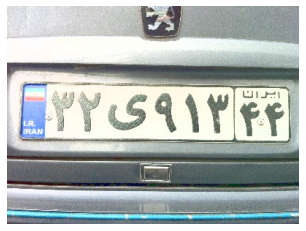

In [ ]:
image = mpimg.imread(os.path.join(DATA_PATH, 'train/0/lighter_0070.jpg'))
plt.imshow(image)
plt.axis('off')
plt.show()

## Implementations

In [ ]:
def recall_m(y_true, y_pred):
    K = tf.keras.backend
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    K = tf.keras.backend
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    K = tf.keras.backend
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Create generator

In [ ]:
train_datagen_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        shear_range=0.25,
                                        width_shift_range=0.25,
                                        height_shift_range=0.25,
                                        zoom_range=0.2,
                                        rotation_range=40)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator_aug  = train_datagen_aug.flow_from_directory(TRAIN_PATH,
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical')
validation_generator  = validation_datagen.flow_from_directory(VALIDATION_PATH,
                                                              target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                              batch_size=BATCH_SIZE,
                                                              class_mode='categorical')
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 5627 images belonging to 3 classes.
Found 271 images belonging to 3 classes.
Found 276 images belonging to 3 classes.


## Define model

In [ ]:
def build_model():
  baseModel = MobileNet(
        include_top=False,
        weights="imagenet",
        input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        pooling='avg',
    )
    
  # for layer in baseModel.layers:
  #     layer.trainable = False
  # for layer in baseModel.layers[-40:]:
  #     layer.trainable = True

  headModel = baseModel.output
  headModel = Dropout(0.2)(headModel)
  headModel = Dense(1024, activation="relu")(headModel)
  headModel = Dropout(0.2)(headModel)
  headModel = Dense(1024, activation="relu")(headModel)
  headModel = Dropout(0.2)(headModel)
  headModel = Dense(512, activation="relu")(headModel)
  headModel = Dropout(0.2)(headModel)
  headModel = Dense(512, activation="relu")(headModel)
  headModel = Dropout(0.2)(headModel)
  headModel = Dense(n_classes, activation="softmax")(headModel)
  
  model = Model(inputs=baseModel.input, outputs=headModel)

  return model

## Compile and fit model

In [ ]:
# learning_rate = 0.0001
weights = '/content/drive/MyDrive/PlateDatasetModels/MobileNet_correctDatasetAug_weights.h5'
callbacks = [ 
              # EarlyStopping(monitor='val_f1_m', patience=20, verbose=0), 
              ModelCheckpoint(weights, monitor='val_f1_m', save_best_only=True, verbose=0, mode='max')
              # ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
            ]
loss = CategoricalCrossentropy()
# optimizer = SGD(lr=1e-2, momentum=0.9, decay=1e-2/40)
optimizer = Adam()
model = build_model()
model.compile(
    loss=loss, 
    optimizer=optimizer, 
    metrics=['accuracy', f1_m, precision_m, recall_m],
)

history = model.fit(
    train_generator_aug, 
    validation_data=validation_generator, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks,
)

17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/60
94/94 [==============================] - 1255s 13s/step - loss: 0.6234 - accuracy: 0.7706 - f1_m: 0.7631 - precision_m: 0.7911 - recall_m: 0.7392 - val_loss: 0.3814 - val_accuracy: 0.8782 - val_f1_m: 0.8862 - val_precision_m: 0.8892 - val_recall_m: 0.8833
Epoch 2/60
94/94 [==============================] - 79s 835ms/step - loss: 0.2043 - accuracy: 0.9330 - f1_m: 0.9334 - precision_m: 0.9405 - recall_m: 0.9266 - val_loss: 0.2691 - val_accuracy: 0.9114 - val_f1_m: 0.9131 - val_precision_m: 0.9192 - val_recall_m: 0.9071
Epoch 3/60
94/94 [==============================] - 79s 833ms/step - loss: 0.1095 - accuracy: 0.9678 - f1_m: 0.9682 - precision_m: 0.9712 - recall_m: 0.9653 - val_loss: 0.3087 - val_accuracy: 0.9151 - val_f1_m: 0.9166 - val_precision_m: 0.9198 - val_recall_m: 0.9135
Epoch 4/60
94/94 [==============================] - 78s 829ms/step - loss: 0.1239 - accuracy: 0.9678 - f1_m: 0.9666 - precision_m: 0.9

## Compile and fit model

In [ ]:
best_model = tf.keras.models.load_model(weights, custom_objects={'f1_m':f1_m, 'precision_m':precision_m, 'recall_m':recall_m})
best_model.compile(
    loss=loss, 
    optimizer=optimizer, 
    metrics=['accuracy', f1_m, precision_m, recall_m]
)

In [ ]:
best_model.evaluate(test_generator, batch_size=BATCH_SIZE)

5/5 [==============================] - 56s 14s/step - loss: 0.1234 - accuracy: 0.9635 - f1_m: 0.9640 - precision_m: 0.9640 - recall_m: 0.9640


[0.1530923992395401,
 0.9528985619544983,
 0.9544442892074585,
 0.9544445276260376,
 0.9544445276260376]

## Save model

In [ ]:
best_model.save("/content/drive/MyDrive/PlateDatasetModels/MobileNet-newDataset.h5")

## Get Reports

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = best_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['0', '1', '2']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[183   6   0]
 [  3  25   1]
 [  0   3  55]]
Classification Report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       189
           1       0.74      0.86      0.79        29
           2       0.98      0.95      0.96        58

    accuracy                           0.95       276
   macro avg       0.90      0.93      0.91       276
weighted avg       0.96      0.95      0.95       276

